# <center> MALARIA DATA VISUALIZATION AND INSIGHTS </center>

## Imports and Other Initialization

In [244]:
#Imports

import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import sqlite3

In [245]:
#Creating database from attached CSV file

malaria_main = pd.read_csv('malaria_deaths_age.csv')
malaria_main = malaria_main.iloc[: , 1:] #Removing redundant index column

malaria_main

db_conn = sqlite3.connect('malaria_deaths_age.db')
c = db_conn.cursor()

c.execute(
    '''
    CREATE TABLE malaria_db (
        entity TEXT,
        code TEXT,
        year INTEGER,
        age_group TEXT,
        deaths DECIMAL
        );

     '''
)

malaria_main.to_sql('malaria_db', db_conn, if_exists='append', index=False)


In [246]:
#Reading database using query and converting it into a Pandas DataFrame
df_main = pd.read_sql_query("SELECT * from malaria_db", db_conn)

df_main = df_main.drop(df_main.index[df_main['code'] == 'OWID_WRL']) #Removing world row

df_sdi = df_main[df_main['entity'].str.contains('SDI')==True] #Separate out SDI countries
df_main = df_main[df_main['entity'].str.contains('SDI')==False] #Removing SDI


df_main


,entity,code,year,age_group,deaths
0,Afghanistan,AFG,1990,Under 5,184.606435
1,Afghanistan,AFG,1991,Under 5,191.658193
2,Afghanistan,AFG,1992,Under 5,197.140197
3,Afghanistan,AFG,1993,Under 5,207.357753
4,Afghanistan,AFG,1994,Under 5,226.209363
...,...,...,...,...,...
30775,Zimbabwe,ZWE,2012,50-69,103.185111
30776,Zimbabwe,ZWE,2013,50-69,100.113293
30777,Zimbabwe,ZWE,2014,50-69,99.013890
30778,Zimbabwe,ZWE,2015,50-69,98.091738


In [247]:
#Data characteristics

print(f"This dataset has {df_main.shape[0]} rows and {df_main.shape[1]} columns.\n")

print("Other stats:")
df_main.describe()

This dataset has 29970 rows and 5 columns.

Other stats:


,year,deaths
count,29970.000000,29970.000000
mean,2003.000000,2244.000037
std,7.789011,23705.619956
min,1990.000000,0.000000
25%,1996.000000,0.000000
50%,2003.000000,0.090395
75%,2010.000000,54.237378
max,2016.000000,706059.061884


In [248]:
#Checking null

df_main.isnull().sum()

entity          0
code         3645
year            0
age_group       0
deaths          0
dtype: int64

In [249]:
df_main[df_main['code'].isna()]["entity"].unique()

array(['Andean Latin America', 'Australasia', 'Caribbean', 'Central Asia',
       'Central Europe', 'Central Latin America',
       'Central Sub-Saharan Africa', 'East Asia', 'Eastern Europe',
       'Eastern Sub-Saharan Africa', 'England',
       'High-income Asia Pacific', 'Latin America and Caribbean',
       'North Africa and Middle East', 'North America',
       'Northern Ireland', 'Oceania', 'Scotland', 'South Asia',
       'Southeast Asia', 'Southern Latin America',
       'Southern Sub-Saharan Africa', 'Sub-Saharan Africa',
       'Tropical Latin America', 'Wales', 'Western Europe',
       'Western Sub-Saharan Africa'], dtype=object)

We find out that there are no specific codes to these regions, and thus they are entered as null values. Since we use country names instead of country codes for grouping, this will not pose an issue.

In [250]:
#Plotting functions

#Bar Plot
def data_graph (axis, width, height):
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    for p in axis.patches:
        axis.annotate ("{0:.1f}".format(p.get_height()), (p.get_x()+width, p.get_height()+height))

#Treemap
def plot_treemap_deaths(dataframe,variable,value):
    fig = px.treemap(dataframe.sort_values(by=value,ascending=False).reset_index(drop=True),
                     path=[variable],values=value,
                     color_discrete_sequence = px.colors.qualitative.Set1)
    fig.data[0].textinfo = 'label+text+value'
    
    fig.show()

## SDI - Based Visualizations

SDI is a summary measure that identifies where countries or other geographic areas sit on the spectrum of development. Expressed on a scale of 0 to 1, SDI is a composite average of the rankings of the incomes per capita, average educational attainment, and fertility rates of all areas in the GBD study.



In [251]:
df_sdi_country = df_sdi.groupby('entity')["deaths"].sum().reset_index().sort_values(by=['deaths'], ascending = False)
df_sdi_country

,entity,deaths
2,Low SDI,1.219046e+07
3,Low-middle SDI,1.069889e+07
4,Middle SDI,3.826359e+05
1,High-middle SDI,2.026336e+04
0,High SDI,1.657167e+02


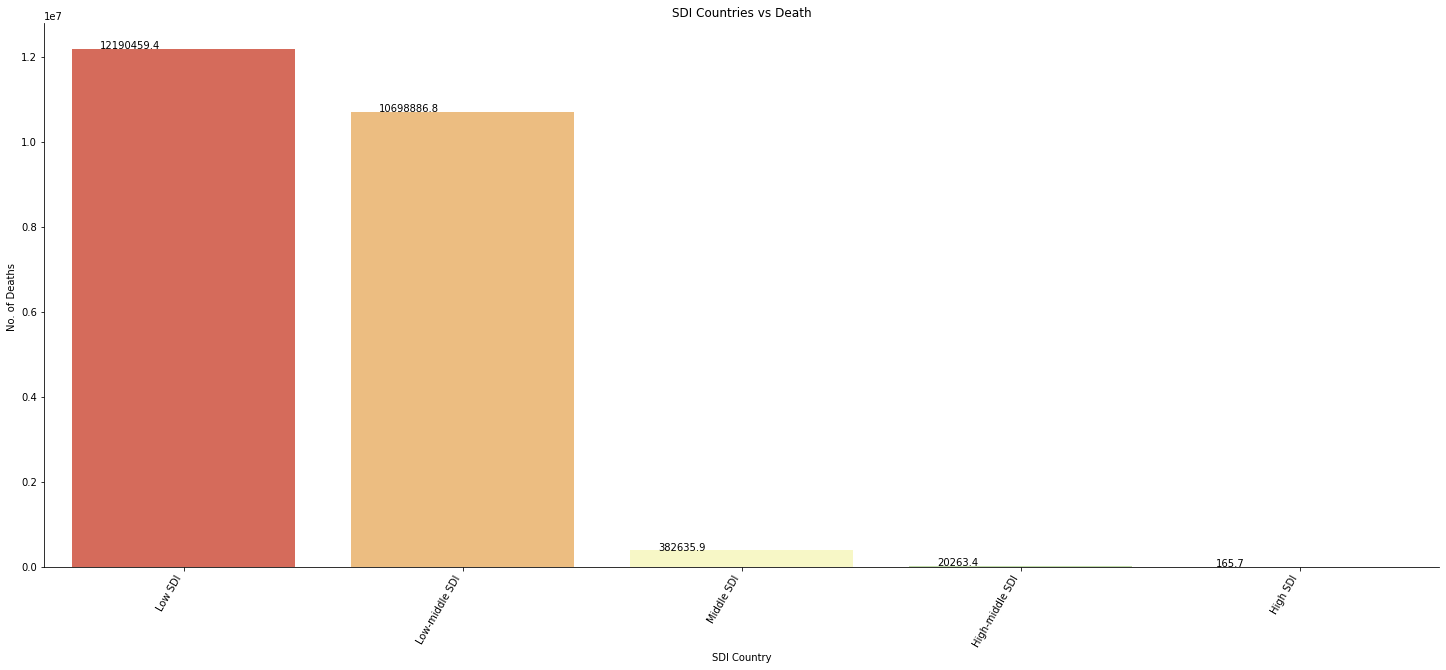

In [252]:
plt.figure(figsize = (25,10))
ax = sns.barplot(x="entity", y= "deaths", data=df_sdi_country ,palette = "Spectral")
plt.title ("SDI Countries vs Death")
plt.xticks(rotation = 60, ha = 'right')
plt.xlabel("SDI Country")
plt.ylabel("No. of Deaths ")
data_graph(ax,0.1,10)
plt.show()

As it can clearlly be seen, due to economic factors, the majority of the malaria cases happen in countries having a low SDI. 

## Country-wise total deaths

In [253]:
df_country = pd.read_sql_query(
    '''
        SELECT entity, SUM(deaths) as deaths 
        FROM malaria_db 
        WHERE NOT entity LIKE '%SDI' AND NOT entity = 'World' 
        GROUP BY entity
        ORDER BY deaths DESC
    ''', db_conn
)
display(df_country)

,entity,deaths
0,Sub-Saharan Africa,2.065353e+07
1,Western Sub-Saharan Africa,1.249095e+07
2,Nigeria,6.781688e+06
3,Eastern Sub-Saharan Africa,5.081947e+06
4,Central Sub-Saharan Africa,3.042293e+06
...,...,...
217,United Kingdom,0.000000e+00
218,United States,0.000000e+00
219,Uruguay,0.000000e+00
220,Wales,0.000000e+00


In [254]:
print(f"Percentage of countries with total deaths = 0:  {round(100*df_country[df_country['deaths']==0]['deaths'].count()/df_country.shape[0], 2)}%\n")

#Removing 0 values to create new dataframe
df_country_not_zeros = df_country.loc[~(df_country['deaths'] == 0)]
df_country_not_zeros

Percentage of countries with total deaths = 0:  40.99%



,entity,deaths
0,Sub-Saharan Africa,2.065353e+07
1,Western Sub-Saharan Africa,1.249095e+07
2,Nigeria,6.781688e+06
3,Eastern Sub-Saharan Africa,5.081947e+06
4,Central Sub-Saharan Africa,3.042293e+06
...,...,...
126,Northern Mariana Islands,4.517036e+00
127,Mauritius,3.662642e+00
128,American Samoa,2.962025e+00
129,United States Virgin Islands,4.143832e-01


As we can see, a large number of regions (40.99%) have 0 deaths per 100,000 people. These are mostly the high SDI countries.

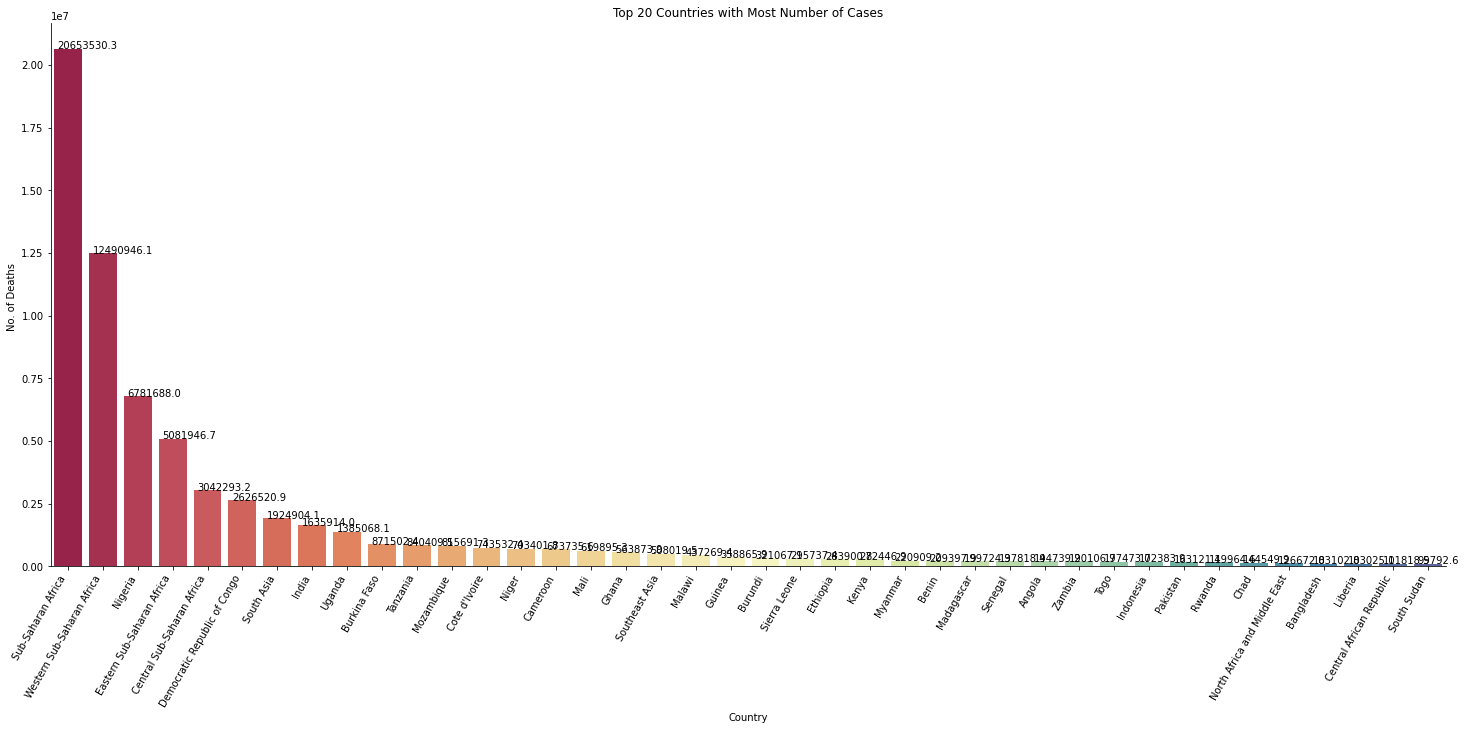

In [255]:
#Bar

plt.figure(figsize = (25,10))
ax = sns.barplot(x="entity", y= "deaths", data=df_country_not_zeros[:40] ,palette = "Spectral")
plt.title ("Top 20 Countries with Most Number of Cases")
plt.xticks(rotation = 60, ha = 'right')
plt.xlabel("Country")
plt.ylabel("No. of Deaths ")
data_graph(ax,0.1,10)
plt.show()

From the bar plot, it is evident that African regions suffer the most from Malaria. 

In [256]:
#Another way of visualization - Treemap

plot_treemap_deaths(df_country,"entity","deaths")

We also visualize the same information using a tree map since it gives us a more intuituve idea about the difference in volume of malaria cases by country.

It can be seen that around 75% of total cases are present in African countries.

## Age-wise total deaths 

In [257]:
#Checking age-wise

df_age = pd.read_sql_query(
    '''
        SELECT age_group, SUM(deaths) as deaths 
        FROM malaria_db 
        WHERE NOT entity LIKE '%SDI' AND NOT entity = 'World' 
        GROUP BY age_group
        ORDER BY deaths DESC
    ''', db_conn
)
display(df_age)

,age_group,deaths
0,Under 5,5.190670e+07
1,5-14,5.944429e+06
2,15-49,4.841826e+06
3,50-69,2.806098e+06
4,70 or older,1.753625e+06


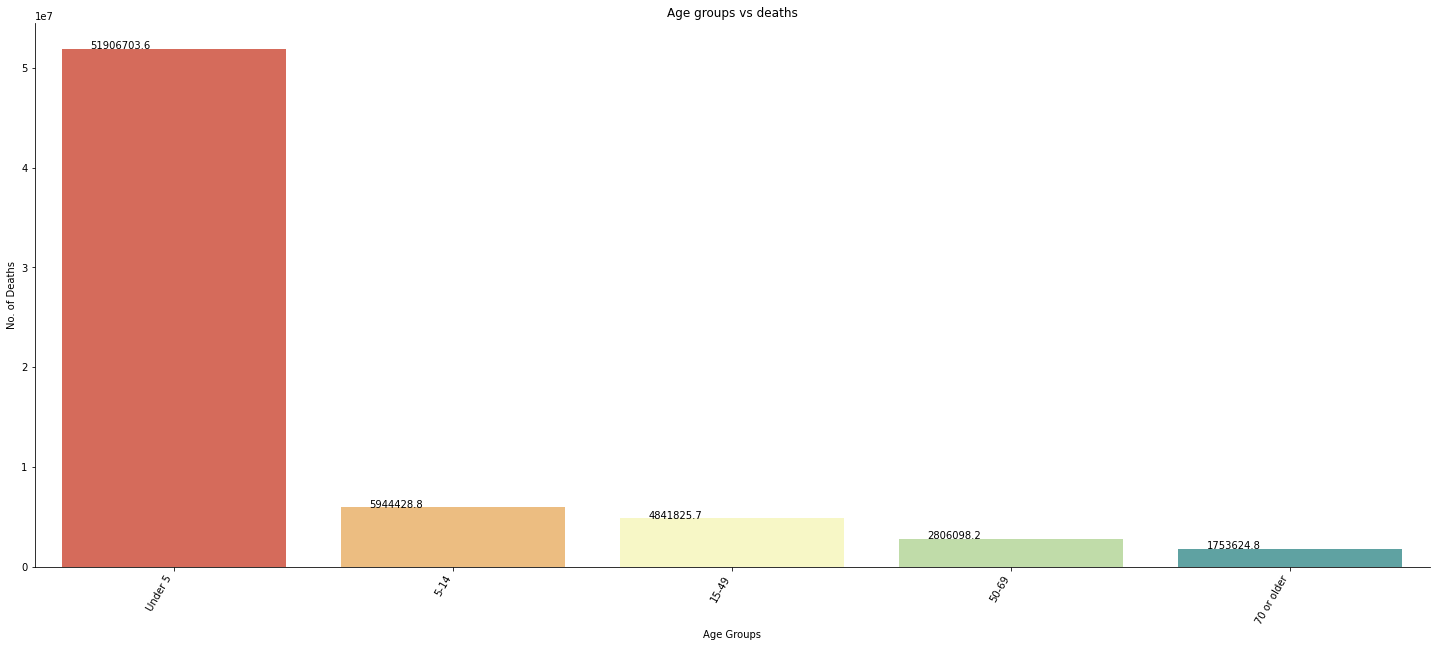

In [258]:
plt.figure(figsize = (25,10))
ax = sns.barplot(x="age_group", y= "deaths", data=df_age ,palette = "Spectral")
plt.title ("Age groups vs deaths")
plt.xticks(rotation = 60, ha = 'right')
plt.xlabel("Age Groups")
plt.ylabel("No. of Deaths")
data_graph(ax,0.1,10)
plt.show()

In [259]:
plot_treemap_deaths(df_age,"age_group","deaths")

It is evident from the graphs that majority of the death take place within children of age under 5.

## Year-wise total deaths

In [260]:
#Checking year-wise

df_year = pd.read_sql_query(
    '''
        SELECT year, SUM(deaths) as deaths 
        FROM malaria_db 
        WHERE NOT entity LIKE '%SDI' AND NOT entity = 'World' 
        GROUP BY year
        ORDER BY deaths DESC
    ''', db_conn
)
display(df_year)

,year,deaths
0,2003,2.869841e+06
1,2004,2.858345e+06
2,2005,2.832688e+06
3,2006,2.817909e+06
4,2002,2.800438e+06
5,2007,2.794417e+06
6,2008,2.767663e+06
7,2001,2.750185e+06
8,2000,2.654928e+06
9,2009,2.653594e+06


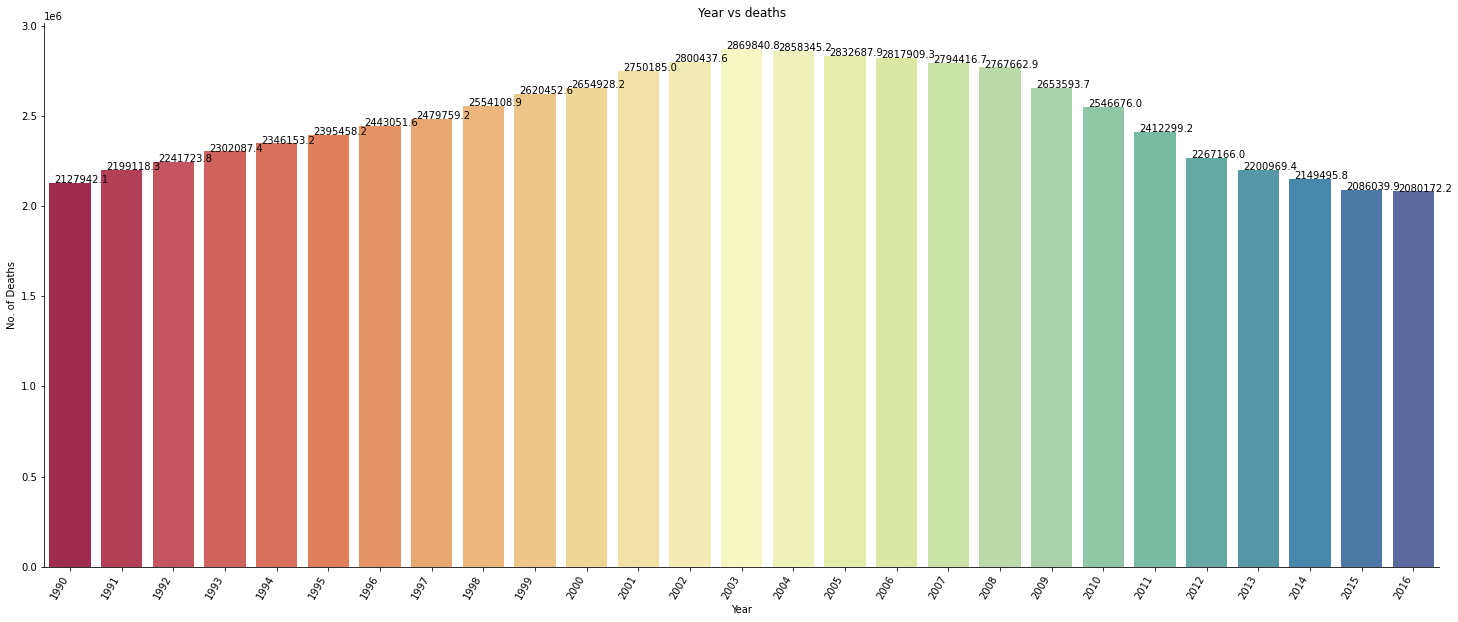

In [261]:
plt.figure(figsize = (25,10))
ax = sns.barplot(x="year", y= "deaths", data=df_year ,palette = "Spectral")
plt.title ("Year vs deaths")
plt.xticks(rotation = 60, ha = 'right')
plt.xlabel("Year")
plt.ylabel("No. of Deaths")
data_graph(ax,0.1,10)
plt.show()

In [262]:
plot_treemap_deaths(df_year,"year","deaths")

The tree plot tells us that the number of cases by years have not changed much, and the bar graph tells us that relatively, the number of cases have begun to fall 2003 onwards, which is around when the malaria vaccination drives started. 

## Situation of Malaria Over the World

In [263]:
df_chloropleth = df_main.groupby(['entity', 'year'])["deaths"].sum().reset_index()
df_chloropleth

,entity,year,deaths
0,Afghanistan,1990,723.939552
1,Afghanistan,1991,777.078123
2,Afghanistan,1992,828.732281
3,Afghanistan,1993,898.777296
4,Afghanistan,1994,997.301821
...,...,...,...
5989,Zimbabwe,2012,1352.575484
5990,Zimbabwe,2013,1343.651716
5991,Zimbabwe,2014,1420.754158
5992,Zimbabwe,2015,1466.800741


In [264]:

fig = px.choropleth(
                    df_chloropleth,

                    locationmode="country names",
                    locations ="entity",

                    hover_data = ["entity","deaths"],
                    hover_name = "entity",

                    color="entity",

                    animation_frame="year", 

                    title="Situation of Malaria Over the World")

fig.show()